# kNN算法寻找更心仪的对象

## 准备数据输入

In [1]:
"""将文本记录转换为numpy可接受的数据格式"""
import numpy as np
import operator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def file2matrix(filename):
    with open(filename,'r') as f:
        arrayOfLines = f.readlines()
        #print(arrayOfLines)
        numberOfLines = len(arrayOfLines) # 返回文件的行数
        #print("文件的行数：%s" % numberOfLines)
        returnMat = np.zeros((numberOfLines,3)) # 创建Numpy矩阵,并以0来填充
        #print("创建的矩阵：")
        #print(returnMat)
        
        classLabelVector = []
        index = 0
        for line in arrayOfLines:
            """解析文件数据到列表"""
            line = line.strip()
            listFromLine = line.split('\t')
            returnMat[index,:] = listFromLine[0:3]
            #classLabelVector.append(np.int(listFromLine[-1])) #TODO:问题语句
            '''
            if listFromLine[-1] == 'largedose':
                classLabelVector.append(2)
            elif listFromLine[-1] == 'smalldose':
                classLabelVector.append(1)
            else:
                classLabelVector.append(0)
            '''    
            classLabelVector.append(listFromLine[-1])
            index += 1
        #将字符串转换为离散数值largedoses为1，didntlike为0，smalldoses为2
        classLabelVector = LabelEncoder().fit_transform(classLabelVector)
    return returnMat,classLabelVector   

file2matrix("data\dating\datingTestSet.txt")

(array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
        [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
        [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
        ...,
        [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
        [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
        [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]]),
 array([1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0,
        2, 1, 2, 1, 2, 1, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 1, 0, 2, 1, 1,
        1, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2,
        1, 2, 1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 2, 2,
        0, 0, 1, 1, 0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 2, 1, 1, 0, 2,
        1, 2, 0, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 2,
        2, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1,
        1, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0,
        1, 2, 1, 0, 1, 2, 0, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1, 0, 1

## 分析数据输入


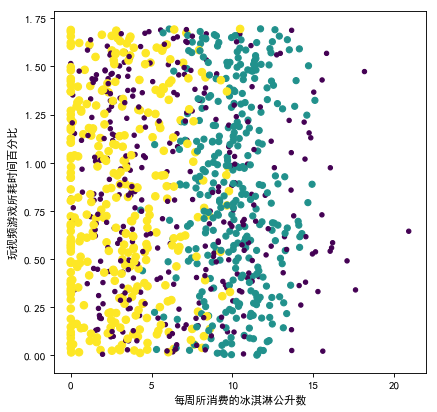

In [3]:
import matplotlib.pyplot as plt

datingDataMat,datingLabels = file2matrix("data\dating\datingTestSet.txt")
fig = plt.figure(figsize=(6,6),dpi=80)
#Matplotlib库支持scatter函数的个性化
ax2 = fig.add_subplot(111)
ax2.scatter(datingDataMat[:,1],datingDataMat[:,2],15.0*(np.array(datingLabels)+1),15.0*(1+np.array(datingLabels)))
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.ylabel('玩视频游戏所耗时间百分比')
plt.xlabel('每周所消费的冰淇淋公升数')

plt.show()

## 归一化

In [7]:
import numpy as np
def norm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - np.tile(minVals,(m,1)) # np.tile函数是对参数1 进行复制，复制参数2指定的行、列次
    normDataSet = normDataSet / np.tile(ranges,(m,1)) # /表示矩阵中元素除法，不是矩阵/矩阵，矩阵除矩阵使用np.solve(A,B)
    
    return normDataSet, ranges, minVals


In [8]:
normMat, ranges, minVals = norm(datingDataMat)
print(normMat)
print(ranges)
print(minVals)

[[0.44832535 0.39805139 0.56233353]
 [0.15873259 0.34195467 0.98724416]
 [0.28542943 0.06892523 0.47449629]
 ...
 [0.29115949 0.50910294 0.51079493]
 [0.52711097 0.43665451 0.4290048 ]
 [0.47940793 0.3768091  0.78571804]]
[9.1273000e+04 2.0919349e+01 1.6943610e+00]
[0.       0.       0.001156]


In [9]:
def classifier_KNN(inX, dataSet, labels, k):
    """
    功能：使用KNN算法，根据已有标记的训练数据集，判断新数据的分类
    输入：  inX，待分类数据（以向量形式表示）；
            dataset：训练集样本集
            labels：标签向量
            k：最近邻居的数量
            
    输出：发生频率最高的元素标签
    """
    dataSetSize = dataSet.shape[0] # 样本数量
    # 按矩阵形式，计算输入向量与所有训练样本的距离
    diffMat = np.tile(inX, (dataSetSize,1)) - dataSet # 把输入数据复制为dataSetSize行，1列的矩阵，减去 dataset
    sqDiffMat = diffMat ** 2 #矩阵元素操作，所有元素求平方
    sqDistances = sqDiffMat.sum(axis = 1) # 对每行数据，计算各列数值的和
    distances = sqDistances ** 0.5 # 对各行的求和值求平方根
    sortedDistIndicies = distances.argsort() #argsort函数返回的是数组值从小到大的索引值
    classCount = {}
    
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]] #根据索引值取出该样本的标签
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1 # 标签（类别）出现一次，累加1
    #print(classCount)
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)# 按类型出现次数逆序排序
    #sorted函数:sorted(iterable,key,reverse)其中iterable表示可以迭代的对象,  key是一个函数，用来选取参与比较的元素，reverse则是用来指定排序是倒序还是顺序operator模块提供的itemgetter函数用于获取对象的哪些维的数据，这里的key=operator.itemgetter(1)，指使key成为一个获取类型计数值的方法
    # sorted函数返回一个列表
    #print(sortedClassCount)
    return sortedClassCount[0][0] #排序后的sortedClassCount是一个列表，元素形式为(label,countvalue)的元组